In [81]:
# 모듈 로딩
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optimizer
from torchmetrics.classification import F1Score,Accuracy
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
import pandas as pd

## 라벨 분류
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Anke boot']

In [82]:
# 데이터
FILE_PATH = 'fashion-mnist_train.csv'
FILE_PATH2 = 'fashion-mnist_test.csv'

In [83]:
train_df=pd.read_csv(FILE_PATH)
test_df=pd.read_csv(FILE_PATH2)

In [84]:
# ? 왜이리크지 28*28
train_df['pixel1'].unique()

array([ 0, 14,  7,  3, 16,  1,  4,  2])

사용자 정의 데이터셋 생성

In [85]:
# 클래스 목적 : 학습용 데이터셋 텐서화 및 전처리
# 클래스 이름 : customDataSet
# 부모클래스 : torch.utils.data.Dataset
# 매개 변수: featureDF, targetDF
class CustomDataset(Dataset):
    # 데이터 로딩 및 전처리 진행과 인스턴스 생성 메서드
    def __init__(self, featureDF, targetDF):
        super().__init__()
        self.featureDF=featureDF
        self.targetDF=targetDF
        self.n_rows=featureDF.shape[0]
        self.n_feaures=featureDF.shape[1]

    # 데이터의 개수 반환 메서드
    def __len__(self) :
        return self.n_rows

    
    # 특정 index의 데이터와 타겟 반환 메서드 => Tensor 반환!!!
    def __getitem__(self, idx) :
        featureTS=torch.FloatTensor( self.featureDF.iloc[idx].values)
        targetTS=torch.FloatTensor( self.targetDF.iloc[idx].values)
        return featureTS, targetTS

In [86]:
featureDF = train_df[train_df.columns[1:]]/255   # 그림이니까 255로 나눠서 정규화
targetDF = train_df[[train_df.columns[0]]]

print(f'featureDF => {featureDF.shape}, targetDF => {targetDF.shape}')

featureDF => (60000, 784), targetDF => (60000, 1)


In [87]:
test_feaureDF = test_df[test_df.columns[1:]]/255
test_targetDF = test_df[[test_df.columns[0]]]

In [88]:
train_dataset = CustomDataset(featureDF, targetDF)
test_dataset= CustomDataset(test_feaureDF, test_targetDF)

In [89]:
train_DL=DataLoader(train_dataset, batch_size=64)
test_DL=DataLoader(test_dataset, batch_size=64)

사용자정의 커스텀 모델 생성

In [90]:
# ---------------------------------------------------------
# 모델 이름 : CustomModel
# 부모클래스 : nn.Module
# 매개 변수 : None
# 모델구조
# -입력층 : 입력 784개    출력 128개   AF ReLU
# -은닉층 : 입력 128개   출력 64개   AF ReLU -> LeakyReLU
# -출력층 : 입력 64개   출력 10개    AF 분류 - 다중 softmax  0,1,2
# ---------------------------------------------------------
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_layer = nn.Linear(784, 128)  
        self.h_layer = nn.Linear(128, 64)  
        self.out_layer = nn.Linear(64, 10)  #10개의 클래스를 분류

    def forward(self, x):
        x = F.relu(self.in_layer(x)) 
        x = F.relu(self.h_layer(x))  
        return self.out_layer(x) # 출력

학습함수 생성

In [91]:
def training(model, dataloader, optimizer, epochs=100):
    TS_loss, TS_score =[[]], [[]]

    for epoch in range(epochs):
        loss_total, score_total = 0, 0

        for dataTS, targetTS in dataloader:
            targetTS = targetTS.reshape(-1).long()
            pre_y = model(dataTS)
        
            loss=nn.CrossEntropyLoss()(pre_y, targetTS)  # 클래스라이렇게함
            loss_total += loss.item()

            score=Accuracy(task='multiclass',num_classes=10)(pre_y, targetTS)
            score_total += score.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        TS_loss[0].append(loss_total/len(dataloader))  # 배치의 평균
        TS_score[0].append(score_total/len(dataloader))


        print(f'[{epoch}//{epochs}]')
        print(f'-Train LOSS : {TS_loss[0][-1]} AcuracyScore : {TS_score[0][-1]}')
    return TS_loss, TS_score

테스트 함수 생성

In [92]:
# testing 함수
def testing(model, dataloader):
    test_loss, test_score = 0,0

    with torch.no_grad():
        for dataTS, targetTS in dataloader:
            targetTS = targetTS.reshape(-1).long()
            pre_y = model(dataTS)

            loss=nn.CrossEntropyLoss()(pre_y, targetTS)  # 클래스라이렇게함
            test_loss += loss.item()

            score=Accuracy(task='multiclass',num_classes=10)(pre_y, targetTS)
            test_score += score.item()

    loss_avg = test_loss/len(dataloader)
    score_avg = test_score/len(dataloader)
    print(f'-Test LOSS : {loss_avg} AcuracyScore : {score_avg}')

    return  loss_avg, score_avg

In [93]:
### 모델 인스턴스 생성
model = CustomModel()
print(model)
summary(model, input_size=(1000,784))

CustomModel(
  (in_layer): Linear(in_features=784, out_features=128, bias=True)
  (h_layer): Linear(in_features=128, out_features=64, bias=True)
  (out_layer): Linear(in_features=64, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
CustomModel                              [1000, 10]                --
├─Linear: 1-1                            [1000, 128]               100,480
├─Linear: 1-2                            [1000, 64]                8,256
├─Linear: 1-3                            [1000, 10]                650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 109.39
Input size (MB): 3.14
Forward/backward pass size (MB): 1.62
Params size (MB): 0.44
Estimated Total Size (MB): 5.19

모델 학습/ 테스트

In [94]:
model = CustomModel()  
optimizer = optimizer.Adam(model.parameters(), lr=0.001) 

loss, score = training(model, train_DL, optimizer, epochs=10)
test_loss, test_score = testing(model, test_DL)

[0//10]
-Train LOSS : 0.5678143997563482 AcuracyScore : 0.8013726012793176
[1//10]
-Train LOSS : 0.40001294220180145 AcuracyScore : 0.857459355010661
[2//10]
-Train LOSS : 0.35691062726382256 AcuracyScore : 0.8710021321961621
[3//10]
-Train LOSS : 0.33008718080739224 AcuracyScore : 0.8802638592750534
[4//10]
-Train LOSS : 0.31046118410125473 AcuracyScore : 0.8872934434968017
[5//10]
-Train LOSS : 0.29401438339337355 AcuracyScore : 0.8920742270788913
[6//10]
-Train LOSS : 0.28035723923969624 AcuracyScore : 0.8958222281449894
[7//10]
-Train LOSS : 0.26800982128264805 AcuracyScore : 0.900369802771855
[8//10]
-Train LOSS : 0.2572857993704551 AcuracyScore : 0.904400986140725
[9//10]
-Train LOSS : 0.24682834769076883 AcuracyScore : 0.9074993336886994
-Test LOSS : 0.3186361148099231 AcuracyScore : 0.8865445859872612


Text(0.5, 1.0, 'Accuracy')

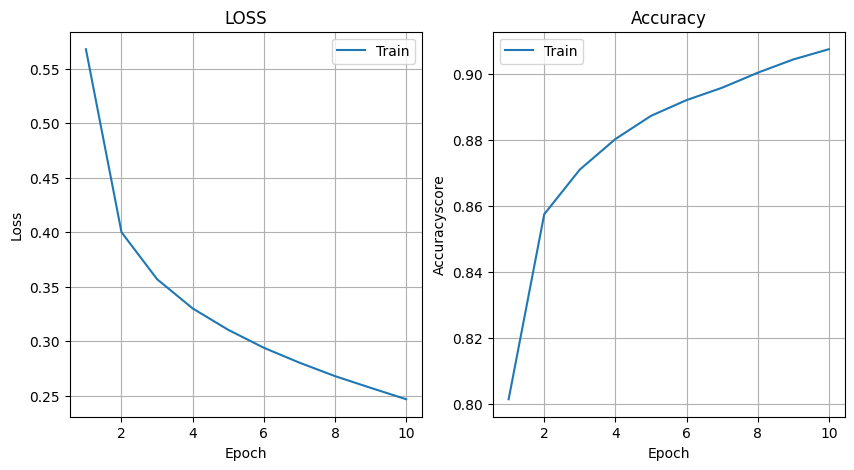

In [95]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt


fg, axes = plt.subplots(1,2 , figsize=(10,5))
axes[0].plot(range(1, 10+1), loss[0], label='Train')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("LOSS")

axes[1].plot(range(1, 10+1), score[0], label='Train')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracyscore")
axes[1].set_title("Accuracy")

데이터셋 첫번째 이미지 예측

In [137]:
first_image, first_label = test_dataset[0]

In [138]:
first_image.shape # 28*28로 나눠야함

torch.Size([784])

In [139]:
with torch.no_grad():
    output = model(first_image.unsqueeze(0)) # 배치 차원 추가 
    predic_label = torch.argmax(output, dim=1).item()


In [140]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Anke boot']

In [141]:
actual_label = first_label.item()

In [142]:
class_names[int(actual_label)]

'T-shirt/top'

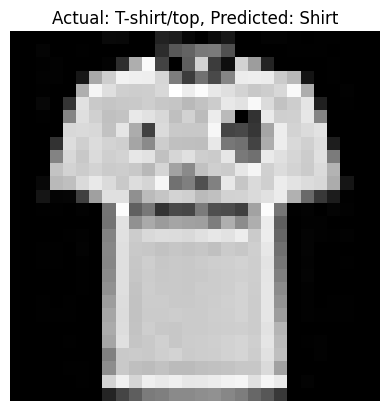

In [143]:
plt.imshow(first_image.view(28,28), cmap='gray')
plt.axis('off')
plt.title(f'Actual: {class_names[int(actual_label)]}, Predict: {class_names[int(predic_label)]}')
plt.show()

이걸 못맞추네